In [4]:
import torch
import torchvision
import torchvision.transforms as transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


In [2]:
torch.cuda.is_available()

True

# Section 1 - Prepare data

Data is loaded from a video and split into frames

In [5]:
transformation = transform.Compose([
    transform.Resize((64, 64)),
    transform.ToTensor()
])

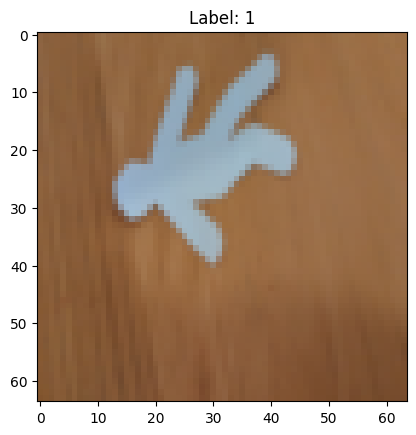

In [30]:
data_dir = "./dataset"
dataset = ImageFolder(root=data_dir, transform=transformation)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
img, l = None, None
for images, labels in data_loader:
    img, l = images[0], labels[0]
    break
img_test = img.permute(1, 2, 0).numpy()
plt.imshow(img_test)
plt.title(f"Label: {l}")
plt.show()


In [31]:
img.shape

torch.Size([3, 64, 64])

In [63]:
# HYPERPARAMETERS
test_len = 0.2
batch_size = 32
kernel_size = 3
stride = 1
padding = 1

In [62]:
from torch.utils.data import random_split

train_size = int((1-test_len) * len(dataset))
test_size = int(test_len * len(dataset))
extra = len(dataset) - (train_size + test_size)
train_size = train_size + extra if extra > 0 else train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False) # no need to shuffle test data
device = "cuda" if torch.cuda.is_available() else "cpu"

In [72]:
# Define NN
from torch import nn

class VictimCNNModelV0(nn.Module):
    def __init__(self, input_channels, hidden_units, output_size):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units*16*16,
                out_features=output_size)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.classifier(x)
        return x

In [108]:
device

'cuda'

In [73]:
model = VictimCNNModelV0(3, 32, 1).to(device)

In [48]:
model.state_dict()

OrderedDict([('conv1.0.weight',
              tensor([[[[ 1.6033e-01, -1.7340e-01,  1.2968e-01],
                        [-1.2204e-01, -3.6341e-02,  1.2403e-01],
                        [ 5.7834e-02,  1.7840e-01,  3.5821e-02]],
              
                       [[-5.7579e-02,  5.3255e-02, -9.7742e-02],
                        [-1.9044e-01,  1.7892e-01, -7.9669e-02],
                        [-3.9279e-02, -1.5045e-01,  2.3700e-02]],
              
                       [[-2.1005e-02,  2.3590e-03, -1.3560e-01],
                        [ 1.5779e-01,  1.5081e-01,  1.6878e-01],
                        [ 1.5745e-01,  1.1303e-01,  1.9092e-01]]],
              
              
                      [[[-1.1220e-01, -1.7875e-02, -1.7101e-01],
                        [ 2.8471e-02, -9.7050e-02,  1.3545e-02],
                        [-8.3213e-02,  1.4303e-01, -2.1494e-02]],
              
                       [[ 1.4548e-01,  1.6819e-01, -1.5244e-01],
                        [-1.2398e-01, -1.08

In [59]:
# Find image dimensions for linear layer
model(img.unsqueeze(0).to(device))

torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 16, 16])


tensor([[0.0243]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [121]:
from torchmetrics import Accuracy
def train_epoch(model,data_loader,loss_fn,optimizer,device):
    train_loss, train_acc = 0,0
    accuracy = Accuracy(task="binary").to(device)
    model.train()
    for batch, (X,y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X).squeeze(1)
        batch_loss = loss_fn(y_pred, y.float())
        train_loss += batch_loss
        y_pred = (y_pred > 0.5).long()
        train_acc += accuracy(y_pred, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

def test_epoch(model,data_loader,loss,optimizer,device):
  test_loss, test_acc = 0, 0
  model.eval()
  accuracy = Accuracy(task="binary").to(device)
  with torch.inference_mode():
    for X,y in test_dataloader:
      X,y = X.to(device), y.unsqueeze(1).to(device)
      test_pred = model(X)
      test_loss += loss(test_pred,y.float())
      test_pred = (test_pred > 0.5).long()
      test_acc +=  accuracy(test_pred, y)
    test_loss/=len(data_loader)
    test_acc/=len(data_loader)
  print(f"\nTest loss: {test_loss:.4f}, Test acc: {test_acc:.2f}% \n")


In [122]:
from tqdm.auto import tqdm

loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 3

for i in tqdm(range(epochs)):
    print(f"Epoch {i+1}\n-------------------------------")
    train_epoch(model, train_dataloader, loss, optimizer, device)
    test_epoch(model, test_dataloader, loss, optimizer, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train loss: 0.02031 | Train acc: 1.00%

Test loss: 0.0004, Test acc: 1.0000% 

Epoch 2
-------------------------------
Train loss: 0.00017 | Train acc: 1.00%

Test loss: 0.0002, Test acc: 1.0000% 

Epoch 3
-------------------------------
Train loss: 0.00009 | Train acc: 1.00%

Test loss: 0.0001, Test acc: 1.0000% 


In [71]:
img, l = None, None
for images, labels in train_dataloader:
    img, l = images[0], labels[0]
    break

for batch, (X,y) in enumerate(train_dataloader):
    print(X.shape)
    print(y.shape)

    break

torch.Size([32, 3, 64, 64])


In [123]:
torch.save(model.state_dict(), 'first_cnn.pth')

In [125]:
model = VictimCNNModelV0(3, 32, 1)  # Initialize a model with the same architecture
model.load_state_dict(torch.load('first_cnn.pth'))
model.to(device)  # Don't forget to move the model to the device

VictimCNNModelV0(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=1, bias=True)
  )
)

In [129]:
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch

# Define the transformation
transformation = Compose([
    Resize((64, 64)),
    ToTensor()
])

# Load the images from the test folder
test_data_dir = "./test"  # Replace with your test folder path
test_dataset = ImageFolder(root=test_data_dir, transform=transformation)

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Load the trained model
model = VictimCNNModelV0(3, 32, 1)  # Initialize a model with the same architecture
model.load_state_dict(torch.load('first_cnn.pth'))
model.to(device)  # Don't forget to move the model to the device
model.eval()  # Set the model to evaluation mode

# Predict the labels for the test images
for images, l in test_dataloader:
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    print(f"Predicted labels: {predicted} | Actual labels: {l}")

Predicted labels: tensor([0, 0, 0, 0], device='cuda:0') | Actual labels: tensor([0, 1, 1, 1])
